# Beoordeling Tijdreeksmodellen
*Auteurs: O.N. Ebbens (Artesia), D.A. Brakenhoff (Artesia)*

Een veelgestelde vraag is hoe je een geoptimaliseerd tijdreeksmodel moet beoordelen. Dit notebook laat zien welke methoden hiervoor gebruikt kunnen worden geillustreerd met voorbeelden.

## Inhoudsopgave

- [Introductie](#Introductie)
- [Visuele beoordeling](#Visuele-beoordeling)
- [Fit statistieken](#Fit-statistieken)
- [Cross validatie](#Cross-validatie)
- [Betrouwbaarheid modelparameters](#Betrouwbaarheid-modelparameters)
- [Correlatie modelparameters](#Correlatie-modelparameters)
- [Hydrologische beoordeling](#Hydrologische-beoordeling)
- [Discussie](#Discussie)
- [Referenties](#Referenties)

## Introductie
Voor het gebruiken of afkeuren van een tijdreeksmodel is het belangrijk om vast te stellen wat het doel van het tijdreeksmodel is. Op basis van dit doel kunnen de criteria worden gesteld voor het beoordelen van het model. In dit notebook worden verschillende methodes toegelicht om tijdreeksmodellen te beoordelen. 

Dit notebook geeft een overzicht van de meest voorkomende methodes om tijdreeksmodellen te beoordelen. Per onderwerp wordt de belangrijkste achtergrondinformatie gepresenteerd, maar het is zeker geen volledig overzicht van al het onderzoek en werk wat op dat vlak is gedaan. Voor de lezers die daarin geinteresseerd zijn hebben we referenties opgenomen waarmee men dieper in het onderwerp kan duiken.



In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pastas as ps
import datetime as dt
from scipy.stats import norm, probplot

# stel de logger in om alleen foutmeldingen naar het scherm te printen
ps.set_log_level("ERROR")

# print de versies van belangrijke Python packages voor pastas
# ps.show_versions(numba=True)

Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.19.2
Scipy version: 1.5.2
Pandas version: 1.2.0
Pastas version: 0.17.0b
Matplotlib version: 3.3.2
numba version: 0.51.2


In [2]:
# hulpfuncties en instellingen voor tabelweergave
cmap = plt.get_cmap("RdBu")
norma = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)

# functie voor kleuren achtergrond voor tabellen
def cbg(val):
    color = mpl.colors.rgb2hex(cmap(norma(val)))
    return f"background-color: {color}"

# functie voor weergeven witte of zwarte tekst in tabellen
def ctxt(val):
    bg = cmap(norma(val))
    c = "White" if np.mean(bg[:3]) < 0.4 else "Black"
    return f"color: {c}"

# functie voor weergeven modelresultaten
def plot_results_ml(ml):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    ml.plot(ax=ax1, legend=False)
    ax1.set_ylabel('Grondwaterstand [m NAP]')
    ax1.grid()
    handles, labels = ax1.get_legend_handles_labels()
    labels = ['Head', 'Simulation']
    ax1.legend(handles, labels, loc="upper left", ncol=2)

    ml.residuals().plot(ax=ax2, color="C1", label="residuals")
    ax2.set_ylabel('Residuen [m]')
    ax2.grid()
    fig.tight_layout()
    
    return fig


# functie voor invullen tabel met fit statistieken
def fit_stats_model(ml):
    stats = [
        "Mean absolute error (mae)",
        "Root mean squared error (rmse)",
        "Sum of the squares of the error (sse)",
        "Explained variance percentage (evp)",
        "R-squared (rsq)"
    ]

    df = pd.DataFrame(index=stats, columns=["waarde", "eenheid"])
    # fit statistics kunnen in pastas worden opgevraagd met:
    # `<model>.stats.<naam statische parameter>()`
    df.loc[stats[0], :] = ml.stats.mae(), "m"
    df.loc[stats[1], :] = ml.stats.rmse(), "m"
    df.loc[stats[2], :] = ml.stats.sse(), "m$^2$"
    df.loc[stats[3], :] = ml.stats.evp(), "%"
    df.loc[stats[4], :] = ml.stats.rsq(), "-"
    
    return df

# functie voor invullen tabel cross validatie
def get_stats_train_test(ml, train_tmin, train_tmax, 
                         test_tmin, test_tmax):
    
    sim = ml.simulate(tmin=train_tmin, tmax=train_tmax)
    obs = ml.oseries.series_original[train_tmin:str(int(train_tmax)-1)]

    stats = [
        "Mean absolute error (mae)",
        "Root mean squared error (rmse)",
        "Sum of squares of the error (sse)",
        "Explained variance percentage (evp)",
        "Nash-Sutcliffe model efficiency (nse)"
    ]

    df = pd.DataFrame(index=stats, columns=[f"training: {train_tmin}-{train_tmax}", f"test: {test_tmin}-{test_tmax}", "eenheid"])

    # statistieken periode 1985 - 2000
    df.loc[stats[0], f"training: {train_tmin}-{train_tmax}"] = ps.stats.mae(obs=obs, sim=sim)
    df.loc[stats[1], f"training: {train_tmin}-{train_tmax}"] = ps.stats.rmse(obs=obs, sim=sim)
    df.loc[stats[2], f"training: {train_tmin}-{train_tmax}"] = ps.stats.sse(obs=obs, sim=sim)
    df.loc[stats[3], f"training: {train_tmin}-{train_tmax}"] = ps.stats.evp(obs=obs, sim=sim)
    df.loc[stats[4], f"training: {train_tmin}-{train_tmax}"] = ps.stats.nse(obs=obs, sim=sim)

    # statistieken periode 2000 - 2015
    sim = ml.simulate(tmin=test_tmin, tmax=test_tmax)
    obs = ml.oseries.series_original[test_tmin:str(int(test_tmax)-1)]
    df.loc[stats[0], f"test: {test_tmin}-{test_tmax}"] = ps.stats.mae(obs=obs, sim=sim)
    df.loc[stats[1], f"test: {test_tmin}-{test_tmax}"] = ps.stats.rmse(obs=obs, sim=sim)
    df.loc[stats[2], f"test: {test_tmin}-{test_tmax}"] = ps.stats.sse(obs=obs, sim=sim)
    df.loc[stats[3], f"test: {test_tmin}-{test_tmax}"] = ps.stats.evp(obs=obs, sim=sim)
    df.loc[stats[4], f"test: {test_tmin}-{test_tmax}"] = ps.stats.nse(obs=obs, sim=sim)

    df.loc[:, "eenheid"] = ["m", "m", "m$^2$", "%", "-"]

    return df

In [3]:
%%html
<style>
table {float:left}
</style>

## Visuele beoordeling

Een eerste, eenvoudige manier om een tijdreeksmodel te beoordelen is door de resultaten te visualiseren. Bijvoorbeeld door de modelsimulatie met de metingen in een grafiek te plotten en de modelresiduën weer te geven. Hieronder staan twee voorbeelden van een visuele beoordeling van een tijdreeksmodel.

<hr>

#### Voorbeeld visuele beoordeling 1
In dit tijdreeksmodel wordt de grondwaterstand verklaard aan de hand van neerslag en verdamping. De modelsimulatie (blauwe lijn) en de metingen (zwarte punten) staan in de bovenste grafiek. De residuen (oranje lijn) zijn in de onderste grafiek weergegeven. 

In de figuur is te zien dat de simulatie en de metingen behoorlijk goed overeen komen. In de residuen is te zien dat het verschil tussen model en meting het grootste is bij de extremen: de dalen in de zomer en de pieken in de winter.

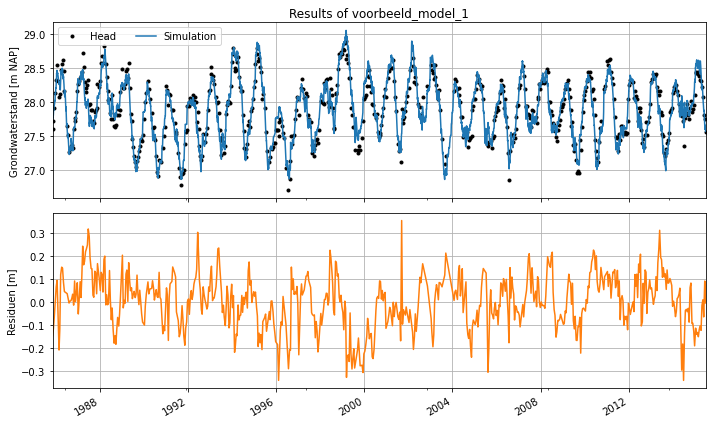

In [4]:
# inladen voorbeeld model
ml1 = ps.io.load("./data/basic_model.pas")

# plot resultaten
f1 = plot_results_ml(ml1)

<hr>

#### Voorbeeld visuele beoordeling 2

Onderstaand voorbeeld laat een tijdreeksmodel zien waar de modelsimulatie (blauwe lijn) slecht overeenkomt met de metingen (zwarte punten). De simulatie wijkt in sommige gevallen wel 2 meter af van de gemeten grondwaterstand.

Met dit model is het niet mogelijk om betrouwbare simulaties te maken.

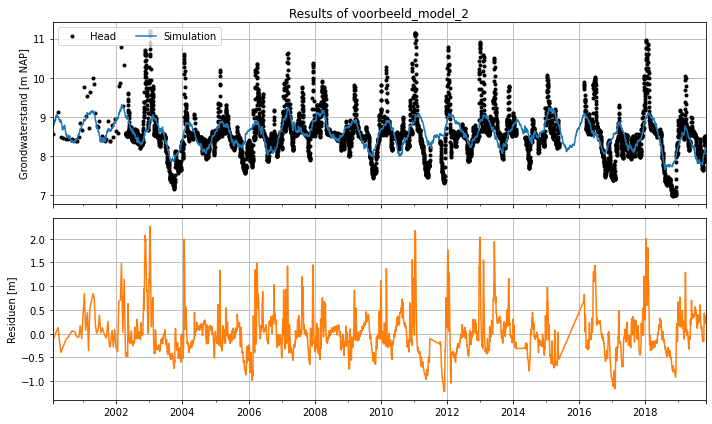

In [5]:
# model uit voorbeeld notebook 
ml_visueel2 = ps.io.load("./data/vb_visueel2.pas")

# plot resultaten
f2 = plot_results_ml(ml_visueel2)

<hr>

## Fit statistieken

Naast de visuele beoordeling kunnen de modelresultaten ook worden beoordeelt met behulp van statistische parameters. Er zijn verschillende statistische parameters om de fit tussen gemodelleerde en gemeten grondwaterstanden in getallen uit te drukken. De statistieken kunnen opgedeeld worden in statistieken die de modelfout (de residuen) uitdrukken als een getal, en statistieken die proberen de "goodness-of-fit" uit te drukken als een getal. [Knotters (2012)](#Referenties) behandelt een aantal fit statistieken van tijdreeksmodellen. [Jackson et al. (2019)](#Referenties) geeft een overzicht van statistieken die gebruikt worden voor hydrologische modellen. In onderstaande tabel zijn een aantal veelgebruikte statistieken opgenomen.

| afkorting 	| statistische parameter 	| formule <sup>$*$</sup>| waarde bij optimale fit 	|  minimum 	|  maximum 	| type  	    |
|:--------------|:--------------------------|:--------------------:|:--------------------------:|:---------:|:---------:|----------------:|
| $\text{SSE}$ 	| som kwadratische fout 	| $$\sum_{i=1}^{N}(y_i - \hat{y_i})^2$$ 	| 0 	| 0 	| $\infty$ 	| residuën 	|
| $\text{MAE}$ 	| gemiddelde absolute fout 	| $$\sum_{i=1}^{N}\frac{\|y_i - \hat{y_i}\|}{N}$$ 	| 0 	| 0 	| $\infty$ 	| residuën 	|
| $\text{RMSE}$ 	| wortel kwadratisch gemiddelde fout 	| $$\sqrt{\sum_{i=1}^{N}\frac{ (y_i - \hat{y_i})^2}{N}}$$ 	| 0 	| 0 	| $\infty$ 	| residuën 	|
| $\text{EVP}$ 	| verklaarde variantie 	|$$\frac{\sigma_y^2 - \sigma_r^2}{\sigma_y^2} * 100$$ 	| 100% 	| 0 	| 100 	| goodness-of-fit 	|
| $R^2$ 	| determinatiecoëfficient 	| $$1-  \frac{\sum_{i=1}^{N}(y_i - \hat{y_i})^2}{\sum_{i=1}^{N}(y_i - \bar{y})^2}$$ 	| 1 	| 0 	| 1 	| goodness-of-fit 	|
| $\text{NSE}$ 	| Nash-Sutcliffe model efficiëntie 	| $$1-  \frac{\sum_{i=1}^{N}(y_i - {f_i})^2}{\sum_{i=1}^{N}(y_i - \bar{y})^2}$$ 	| 1 	| $-\infty$ 	| 1 	| prognosefout	|

<sup>*</sup> $N$ is het aantal metingen, $y_i$ en $\hat{y_i}$ zijn de gemeten en met het model gefitte grondwaterstand op tijdstip $i$, respectievelijk. $f_i$ is de met het model voorspelde grondwaterstand op tijdstip $i$ en $\sigma_y^2$ en $\sigma_r^2$ zijn de variantie in de gemeten grondwaterstanden en de variantie van de residuën, respectievelijk.

### Verschillen $R^2$, $\text{NSE}$ en $\text{EVP}$

De $R^2$ en $\text{NSE}$ worden regelmatig door elkaar gebruikt omdat ze grote gelijkenissen vertonen. Het verschil zit hem in de toepassing. De $R^2$ wordt gebruikt om te kijken hoe goed het lukt om een model te fitten op metingen, de $\text{NSE}$ om te kijken hoe goed een modelvoorspelling past bij metingen. De $\text{NSE}$ kan negatief worden, omdat de gekwadrateerde fout van de modelvoorspelling groter kan zijn dan de totale gekwadrateerde som. In het geval van de $R^2$ is het slechtst mogelijke model in theorie het gemiddelde van de metingen waardoor de waarde van $R^2$ nooit lager kan worden dan nul.

Ook de $\text{EVP}$ en de $R^2$ tonen veel gelijkenissen. In principe verschilt de $\text{EVP}$ in waarde van de $R^2$ tenzij het gemiddelde van de modelresiduën gelijk is aan nul. In dat geval is de waarde van de $R^2$, mits uitgedruk als percentage, gelijk aan de $\text{EVP}$. Bij modellen die gefit zijn op de metingen is het gemiddelde van de modelresiduën over het algemeen nagenoeg gelijk aan nul.

<hr>

#### Voorbeeld fit statistiek 1

De fit statistieken van het hierboven weergegeven model. De gemiddelde absolute modelfout bedraagt ca. 9 cm. De fit-statistieken geven aan dat het model goed overeenkomt met de metingen; de verklaarde variantie (of EVP) is 92,9%. 

In [6]:
# bereken statistieken tabel
df = fit_stats_model(ml1)

# geef tabel weer
df.style.set_precision(3).set_caption("Fit statistieken voorbeeld_model_1")

,waarde,eenheid
Mean absolute error (mae),0.090,m
Root mean squared error (rmse),0.114,m
Sum of the squares of the error (sse),8.431,m$^2$
Explained variance percentage (evp),92.926,%
R-squared (rsq),0.929,-


<hr>

#### Voorbeeld fit statistiek 2

De fit statistieken van het tweede voorbeeldmodel zijn een stuk slechter. Zoals ook al visueel aangegeven komt het model niet overeen met de metingen. De R-squared waarde is slechts 0.39 en de gemiddelde afwijking maar liefst 33 cm. 

In [7]:
# bereken statistieken tabel
df = fit_stats_model(ml_visueel2)

# geef tabel weer
df.style.set_precision(3).set_caption("Fit statistieken voorbeeld_model_2")

,waarde,eenheid
Mean absolute error (mae),0.326,m
Root mean squared error (rmse),0.464,m
Sum of the squares of the error (sse),1281.269,m$^2$
Explained variance percentage (evp),38.597,%
R-squared (rsq),0.386,-


<hr>

### Overfitting

Als er meer verklarende variabelen (en daarmee modelparameters) aan een tijdreeksmodel worden toegevoegd wordt de fit over het algemeen beter, zelfs als de verklarende variabele helemaal geen invloed heeft op de grondwaterstand. Het model kan deze extra vrijheidsgraden (parameters) namelijk gebruiken om het model beter op de metingen te fitten. Het toevoegen van een niet-relevante verklarende variabele zorgt niet voor een verbetering in de voorspellende waarde van het model. Het fenomeen waarbij meer parameters aan een model worden toegevoegd dan gerechtvaardigd is op basis van de data heet overfitting. 

Dit is belangrijk omdat het dus niet altijd mogelijk is om op basis van de fit statistieken aan te geven of het model verbetert na het toevoegen van een verklarende variabele. Er bestaan diverse methodes om te bepalen of de voorspellende waarde van een model verbetert na het toevoegen van verklarende variabelen. [Poeter et al. (2005)](#referenties) laat een aantal methodes zien om modellen op dit criteria te beoordelen.

<p style="color:red">%% PM: Referentie van geer 2012%%</p>

## Cross validatie

Cross-validatie is een methode om tijdreeksmodellen te beoordelen. In plaats van de term cross-validatie wordt ook vaak gesproken over model validatie. Hierbij wordt een tijdreeks opgesplitst in twee delen, een trainings-deel en een test-deel. Een deel van de metingen wordt gebruikt om het model te kalibreren en wordt de trainings-dataset genoemd. Vervolgens wordt het gekalibreerde model gebruikt om een simulatie te berekenen voor de tweede periode. Dit deel wordt de test-dataset genoemd. De simulatie wordt vergeleken met de metingen om te beoordelen of het model ook goede resultaten oplevert voor het deel waar het niet op gekalibreerd is. Een tijdreeks moet voldoende lang zijn en voldoende metingen bevatten om deze op te kunnen splitsen trainings-deel en een test-deel.

Als het model goed presteert in de test-periode dan is het model dat is afgeleid op basis van de trainings-periode goed genoeg om de grondwaterstanden te voorspellen in die periode. Dat geeft vertrouwen dat het model goed presteert, maar dat betekent niet per definitie dat het model ook in de toekomst goede voorspellingen zal geven. Als er in de toekomst iets structureel veranderd in het systeem (b.v. een onttrekking die start maar niet in het model is opgenomen), dan zal het model dat uiteraard niet goed voorspellen. 

Als het model een goede fit heeft in de trainings-periode maar niet in de test-periode, dan is het model geen goede voorspeller van de grondwaterstand. Dit kan verschillende oorzaken hebbben bijvoorbeeld veranderingen in het systeem die tijdens de test-periode hebben plaatsgevonden, zoals de start van een nieuwe onttrekking of het dempen van een watergang, of het meenemen van een invloed in het model die tijdens te trainingsperiode nog niet actief was.

De hierboven besproken [fit statistieken](#Fit-statistieken) kunnen ook gebruikt worden om de voorspelling in de testperiode te toetsen. In dit geval is in plaats van de $R^2$ de $\text{NSE}$ toegepast omdat het om een voorspelling met het model gaat. Voor een uitgebreide analyse van een set aan tijdreeksmodellen met deze methode, inclusief een beschouwing van bijbehorende fit-statistieken, zie [Knotters (2012)](#Referenties).

<hr>

#### Voorbeeld cross validatie 1

De cross validatie is uitgevoerd voor het voorbeeldmodel hierboven. De dataset is in twee periodes opgesplitst. Het model is getraind op de periode 1985 - 2000 en getest op de periode 2000 - 2015. De resultaten staan in de plots hieronder evenals de berekende fit statistieken beide periodes. 

Het model presteert vrij goed in de test periode wat vertrouwen geeft in de voorspellende waarde van het model. De EVP is in de testperiode weliswaar 3 procentpunt lager dan in de trainingsperiode maar met 90,5% nog steeds relatief hoog.

In [8]:
# train het model op periode 1985 - 2000, test het model op de periode 2000 - 2015
ml_train1 = ml1.copy()
ml_train1.solve(tmin='1985', tmax='2000', report=False)

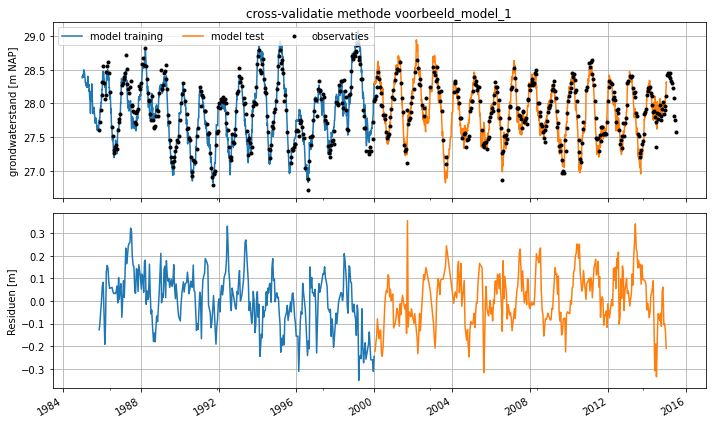

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax1.plot(ml_train1.simulate(tmin='1985', tmax='2000'), label='model training')
ax1.plot(ml_train1.simulate(tmin='2000', tmax='2015'), label='model test')
ax1.plot(ml_train1.oseries.series_original, ls='', marker='.',
         label='observaties', color='k')
ax1.legend(loc="upper left", ncol=3)
ax1.grid()
ax1.set_title('cross-validatie methode voorbeeld_model_1')
ax1.set_ylabel('grondwaterstand [m NAP]')

ml_train1.residuals(tmin='1985', tmax='2000').plot(ax=ax2, label="residuals train")
ml_train1.residuals(tmin='2000', tmax='2015').plot(ax=ax2, label="residuals test")
ax2.set_ylabel('Residuen [m]')
ax2.grid()
fig.tight_layout()

In [10]:
df = get_stats_train_test(ml_train1,  '1985',  '2000', '2000', '2015')
df.style.set_precision(3).set_caption("Statistieken voor cross validatie voorbeeld_model_1")

,training: 1985-2000,test: 2000-2015,eenheid
Mean absolute error (mae),0.097,0.094,m
Root mean squared error (rmse),0.123,0.117,m
Sum of squares of the error (sse),4.727,4.353,m$^2$
Explained variance percentage (evp),93.441,90.524,%
Nash-Sutcliffe model efficiency (nse),0.934,0.905,-


<hr>

#### Voorbeeld cross-validatie 2

Bij de cross-validatie methode wordt vaak een trainingsperiode in het verleden gekozen en een testperiode die daarna ligt. Deze kunnnen echter ook worden omgedraaid. In onderstaand voorbeeld is hetzelfde model gebruikt als in het vorige voorbeeld maar zijn de trainings- en testperiode omgedraaid.

De resultaten laten eenzelfde beeld zien als in het eerste voorbeeld. De EVP in de periode 2000-2015 is verbetert met 2 procentpunten. Deze toename is verklaarbaar omdat het model nu gefit is op deze periode. Daarnaast valt op dat het model nu in de trainingsperiode een slechtere EVP en NSE waarde heeft dan in de testperiode. Dit wordt waarschijnlijk veroorzaakt door slecht verklaarbare metingen in de trainingsperiode.

In [11]:
# train het model op periode 2000 - 2015, test het model op de periode 1985 - 2000
ml_train2 = ml1.copy()
ml_train2.solve(tmin='2000', tmax='2015', report=False)

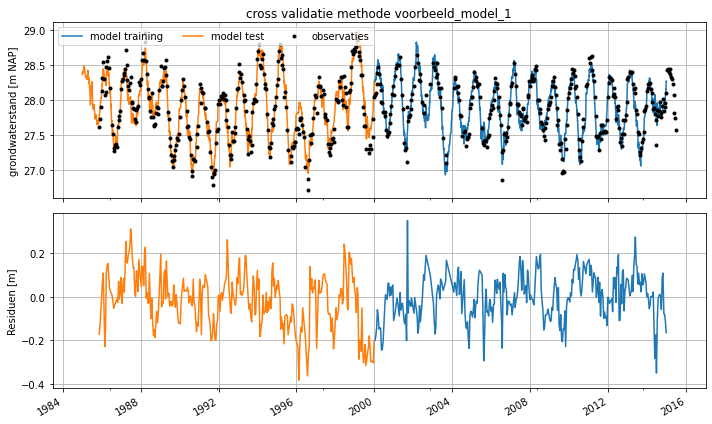

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax1.plot(ml_train2.simulate(tmin='2000', tmax='2015'), label='model training')
ax1.plot(ml_train2.simulate(tmin='1985', tmax='2000'), label='model test')
ax1.plot(ml_train2.oseries.series_original, ls='', marker='.',
         label='observaties', color='k')
ax1.legend(loc="upper left", ncol=3)
ax1.grid()
ax1.set_title('cross validatie methode voorbeeld_model_1')
ax1.set_ylabel('grondwaterstand [m NAP]')

ml_train2.residuals(tmin='2000', tmax='2015').plot(ax=ax2, label="residuals test")
ml_train2.residuals(tmin='1985', tmax='2000').plot(ax=ax2, label="residuals train")
ax2.set_ylabel('Residuen [m]')
ax2.grid()
fig.tight_layout()

In [13]:
df = get_stats_train_test(ml_train2, '2000', '2015', '1985',  '2000')
df.style.set_precision(3).set_caption("Statistieken voor cross validatie voorbeeld_model_1")

,training: 2000-2015,test: 1985-2000,eenheid
Mean absolute error (mae),0.080,0.096,m
Root mean squared error (rmse),0.101,0.124,m
Sum of squares of the error (sse),3.299,4.855,m$^2$
Explained variance percentage (evp),92.776,93.393,%
Nash-Sutcliffe model efficiency (nse),0.928,0.933,-


<hr>

#### Voorbeeld cross-validatie 3

Hieronder een voorbeeld van een model met een goede fit in de trainingsperiode en een slechte fit in de testperiode. De slechte fit wordt veroorzaakt door een sprong in de grondwaterstanden in 2007. Deze sprong is veroorzaakt door een externe invloed die niet is meegenomen bij het trainen van het model. Het zal daarom niet mogelijk zijn om met het model een goede fit te krijgen voor de testperiode.

In [14]:
ml_cross_validatie = ps.io.load('data/vb_cross_validatie2.pas')
ml_cross_validatie.solve(tmin='1990', tmax='2002', report=False)

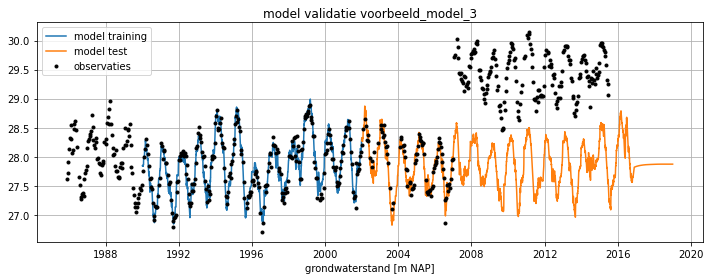

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ml_cross_validatie.simulate(tmin='1990', tmax='2002'), label='model training')
ax.plot(ml_cross_validatie.simulate(tmin='2002', tmax='2019'), label='model test')
ax.plot(ml_cross_validatie.oseries.series_original, ls='',
        marker='.', label='observaties', color='k')
ax.legend()
ax.grid()
ax.set_title('model validatie voorbeeld_model_3')
ax.set_xlabel('grondwaterstand [m NAP]')
fig.tight_layout()

In [16]:
df = get_stats_train_test(ml_cross_validatie,  '1990',  '2003', '2003', '2019')
df.style.set_precision(3).set_caption("Statistieken voor cross validatie voorbeeld_model_3")

,training: 1990-2003,test: 2003-2019,eenheid
Mean absolute error (mae),0.091,1.132,m
Root mean squared error (rmse),0.115,1.315,m
Sum of squares of the error (sse),3.637,474.127,m$^2$
Explained variance percentage (evp),93.994,23.061,%
Nash-Sutcliffe model efficiency (nse),0.940,-1.696,-


<hr>

## Betrouwbaarheid modelparameters<a name="betrouwbaarheid"></a>

Tijdreeksmodellen kunnen ook beoordeeld worden aan de hand van de berekende onzekerheden van de modelparameters. Het is goed voor te stellen dat een model waarvan de parameters lastig te bepalen zijn (de parameters zijn onzeker) minder betrouwbaar wordt geacht dan een model waarbij de parameters goed vast te stellen zijn (met een kleine onzekerheid).

<p style="color:red">%% PM: Referentie naar Pastas notebook model diagnostiek? %%</p>

<p style="color:red">%% PM: Nalopen wat relevant is %%</p>


Naast de beoordeling van de model fit is het ook van belang om te kijken naar de modelparameters. Externe invloeden worden gemodelleerd met responsfuncties die ieder één of meerdere parameters bevatten. Daarnaast kunnen in tijdreeksmodellen ook nog een constante en een noisemodel worden toegevoegd. In het voorbeeld hieronder zijn de parameters weergegeven van een tijdreeksmodel met recharge als externe invloed. 

Per parameter zijn de volgende waarden weergegeven:
- **initial**: de initiële waarde
- **optimal**: de geoptimaliseerde waarde
- **pmin en pmax**: de bandbreedte waarbinnen de parameters worden geoptimaliseerd
- **stderr**: de standaarddeviatie van de geoptimaliseerde parameter

De berekende standaarddeviaties zijn alleen betrouwbaar als aan een aantal voorwaarden wordt voldaan. Deze voorwaarden zijn hieronder uitgewerkt. Daaronder wordt behandeld hoe je de standaarddeviatie kan gebruiken om meer inzicht te krijgen in de modelresultaten.

<div class="alert alert-info">
    
<b>vuistregel:</b> 
    
Als de standaarddeviaties van de parameters worden gebruiktt, is een diagnostische check van het ruismodel nodig.
    
</div>





De berekende standaarddeviaties zijn betrouwbaar als aan een aantal voorwaarden wordt voldaan. De twee voorwaarden voor de met het ruismodel berekende ruis zijn dat het:
1. zich gedraagt als witte ruis met een gemiddelde van nul.
2. niet gecorreleerd is aan een verklarende tijdreeks.

Er is sprake van witte ruis wanneer:
1. er geen significante autocorrelatie in de ruis aanwezig is
2. de ruis homoscedastisch is
3. de ruis voldoet aan een, bij voorkeur normale, statistische verdeling.

De verschillende voorbeelden worden hieronder uitgewerkt aan de hand van een voorbeeld
<hr>

### Correlatie verklarende tijdreeks

<p style="color:red">%% PM %%</p>

### Autocorrelatie

Het kan gebeuren dat een tijdreeks gecorreleerd is met een in de tijd verschoven versie van zichzelf. Als dat het geval is spreken we van autocorrelatie. Deze vorm van correlatie kan worden weergegeven in een autocorrelatiediagram zoals hieronder. Hierin is op de x-as de verschuiving in de tijd weergegeven (lag) en op de y-as de berekende correlatie. 

<hr>

#### Voorbeeld autocorrelatiediagram

De autocorrelatie wordt weergegeven tot een maximale verschuiving van 1 jaar (365 dagen). De blauwe band in de grafiek geeft het 95% betrouwbaarheidsinterval weer. Wanneer 95% van de berekende autocorrelaties binnen dit interval liggen kunnen we concluderen dat er geen significante autocorrelatie aanwezig is in de reeks.

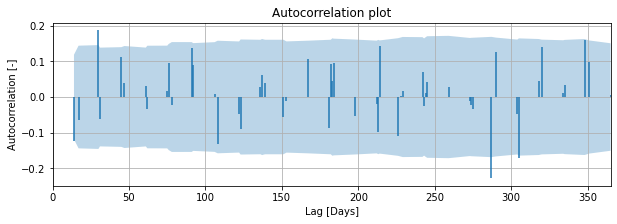

In [17]:
ax = ps.stats.plot_acf(ml1.noise(), figsize=(10, 3), alpha=0.05)

### Normale verdeling ruis

Een voorwaarde voor witte ruis is dat deze voldoet aan een, bij voorkeur normale, statistische verdeling. De verdeling van de ruis kan weergegeven worden met een histogram in combinatie met een kansverdeling. Op basis van onderstaand voorbeeld kan worden geconcludeerd dat de verdeling van de ruis de normale verdeling voldoende goed benaderd om het model op dit aspect goed te keuren

<hr>

#### Voorbeeld visualisatie normale verdeling ruis

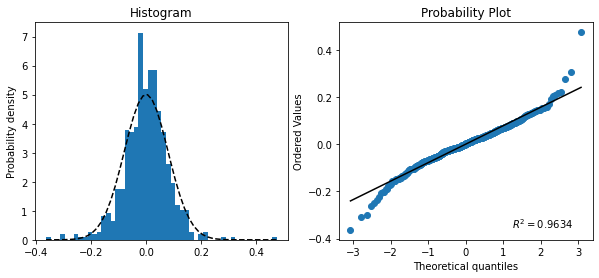

In [18]:
# Plot the histogram for normality and add a 'best fit' line
bins = 50
series = ml1.noise()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
_, bins, _ = ax1.hist(series.values, bins=bins, density=True)
y = norm.pdf(bins, series.mean(), series.std())
ax1.plot(bins, y, 'k--')
ax1.set_ylabel("Probability density")
ax1.set_title("Histogram")

# Plot the probability plot
probplot(series, plot=ax2, dist="norm", rvalue=True)
ax2.get_lines()[0].set_color('C0')
ax2.get_lines()[1].set_color("k")

### Homoscedasticiteit

Een reeks is homoscedastisch als alle waarden dezelfde eindige variantie hebben. Bij ons tijdreeksmodel betekent dit dat de ruis onafhankelijk is van de gemeten grondwaterstanden. Dit is hieronder visueel weergegeven door deze waarden tegen elkaar uit te zetten in een grafiek. In onderstaande grafiek is geen duidelijk verband zichtbaar tussen de gemeten grondwaterstand en de ruis. De ruis lijkt dus homoscedastisch.

Wanneer de ruis niet homoscedastisch, oftewel heteroscedastisch, is dan is de grootte van de ruis afhankelijk van de grondwaterstand.

<hr>

#### Voorbeeld visualisatie homoscedasticiteit

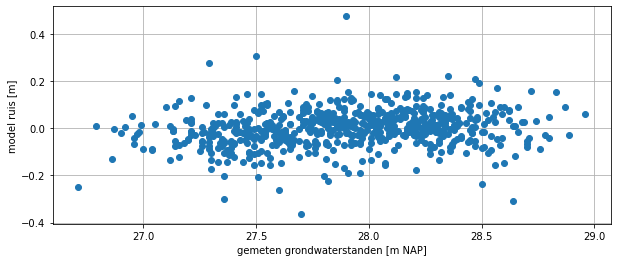

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(ml1.observations(), ml1.noise(), marker="o", linestyle=" ")
ax.set_xlabel("gemeten grondwaterstanden [m NAP]")
ax.set_ylabel("model ruis [m]")
ax.grid()

## Correlatie modelparameters

Tijdens het optimaliseren van een tijdreeksmodel wordt ook de correlatie tussen de geschatte parameters berekend. Als twee parameters sterk gecorreleerd zijn betekent dat deze in de optimalisatie moeilijk van elkaar te onderscheiden zijn. Dit heeft meestal geen invloed op de voorspellende kracht van het tijdreeksmodel in zijn geheel, maar mogelijk wel op het inschatten van individuele bijdrages van de verklarende variabelen.

<hr>

#### Voorbeeld parameter correlaties 1

Je maakt een grondwatermodel met als verklarende reeksen recharge en oppervlaktewaterpeilen. Het model presteert goed maar de parameters van beide verklarende variabelen zijn sterk gecorreleerd. Het model is daardoor niet geschikt om de invloed van recharge en oppervlaktewater van elkaar te scheiden. Dus kan het model niet gebruikt worden om het effect van een stijging in het oppervlaktewaterpeil te berekenen. Het is immers niet duidelijk of de stijging van de grondwaterstand wordt veroorzaakt door toegenomen recharge of door een stijging van het oppervlaktewaterpeil. 

Het model kan nog wel bruibkaar zijn voor andere doeleinden. Als er bijvoorbeeld een grondwateronttrekking is gestart in de omgeving kan het effect daarvan mogelijk wel met het model bepaald worden. Voor het bepalen van dat effect is het immers niet van belang om de invloeden van recharge en oppervlaktewater van elkaar te scheiden.

<p style="color:red">%% PM: invullen pastas model met rivier %%</p>

In [20]:
# invullen pastas model met rivier

<hr>

#### Voorbeeld parameter correlaties 2

<p style="color:red">%% PM: voorbeeld met gecorreleerde onttrekkingsreeksen %%</p>

In [21]:
# invullen pastas model met gecorrelleerde onttrekkingen

<hr>

## Hydrologische beoordeling<a id='hydrologische beoordeling'></a>

Tijdreeksmodellen worden veel gebruikt om systeem-identificatie uit te voeren, waarbij de bijdrages van verschillende invloeden aan veranderingen in de stijghoogte worden ingeschat. Vanuit vraagstukken uit de praktijk wordt tijdreeksanalyse vaak toegepast op een heel meetnet, of op meerdere peilbuizen binnen een interessegebied. De hydrologische beoordeling van individiuele, maar ook hele sets van tijdreeksmodellen is interessant om uit te voeren. 

### Hydrologie<a id='hydrologie'></a>

Het beoordelen van modellen op basis van hydrologische aspecten kan allerlei vormen aannemen. De vraag daarbij is eigenlijk "is hetgeen dat ik bereken hydrologisch plausibel?". Daarbij zijn modellen die wel aan de verwachtingen voldoen net zo interessant als de modellen die daar niet aan voldoen. 

Door de modellen op hydrologische aspecten te toetsen wordt het inzicht in het systeem vergoot. 



<hr>

#### Voorbeeld hydrologische beoordeling 1

<p style="color:red">%% PM: echte voorbeelden met winning invoegen %%</p>

Als voorbeeld van een hydrologische beoordeling van een tijdreeksmodel wordt de respons van een onttrekking beschouwd. In onderstaande figuur zijn twee verschillende stapresponsen weergegeven met een onzekerheidsbandbreedte. De bandbreedte van 2x de standaardafwijking is in dit geval berekend aan de hand van de onzekerheid in de gain parameter (de parameter die het stationaire effect van de onttrekking bepaald). In de linker grafiek is de onzekerheid van de staprespons klein, met andere woorden, de parameters kunnen relatief nauwkeurig bepaald worden in de optimalisatie. In de rechter grafiek is deze onzekerheid veel groter, de invloed van de onttrekking kan dus niet nauwkeurig worden ingeschat in de optimalisatie. In dit geval betekent een positieve staprespons dat de onttrekking een verlaging van de stijghoogte veroorzaakt.


<br>
<center><img src='data/stationaire_invloed.png' width=75% alt='stationaire invloed met onzekerheid'/></center>
<center><b><em>Stationaire invloed van een onttrekking met een kleine onzekerheid (links) en een grote onzekerheid (rechts).</em></b></center>
<br>

Vanuit de hydrologie moet de onttrekking voor een daling van de grondwaterstand zorgen, maar in het geval van het onzekere model (rechts) is er een een meer dan 5%-kans dat de onttrekking een verhoging van de grondwaterstand veroorzaakt. De bandbreedte is dusdanig groot dat er een kans is dat de staprespons ook negatief kan zijn. In dat geval kunnen we stellen dat dat hydrlogisch gezien niet plausibel is, en dat dit model waarschijnlijk niet goed is. De onttrekking heeft mogelijk geen significante invloed op de stijghoogte.

<hr>


### Geheugen van de responsfunctie

<p style="color:red">%% PM %%</p>

<hr>

#### Voorbeeld bepalen geheugen van de responsfunctie

Het bepalen van het geheugen van de responsfunctie is niet altijd even vanzelfsprekend. Regelmatig worden exponentiële responsfuncties gebruikt met een horizontale asymptoot op y=0, de respons zal dus nooit gelijk zijn aan 0. Het is daarom niet mogelijk om het geheugen te bepalen door te kijken wanneer de respons 0 is. Om deze reden wordt als maat voor het geheugen vaak de tijd genomen die het duurt voordat 95% van de respons is uitgewerkt. Hieronder is dit visueel weergegeven.

geheugen (t95) -> 477 dagen


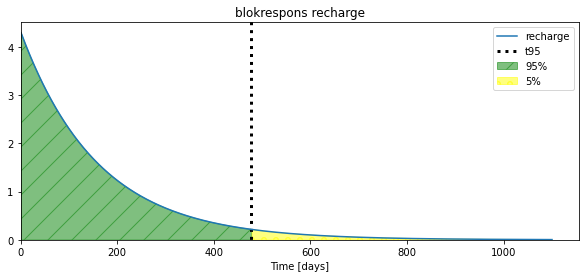

In [22]:
sm = ml1.stressmodels['recharge']
resp_func = sm.rfunc
t95 = resp_func.get_tmax(ml1.get_parameters('recharge'), cutoff=0.95)
print(f'geheugen (t95) -> {t95:.0f} dagen')

ax = ml1.plots.block_response(figsize=(10, 4))
ylim = ax.get_ylim()
ax.vlines(t95, -100, 100, ls=':', color='k', label='t95', lw=3)

block_response = sm.rfunc.block(ml1.get_parameters('recharge'))

ax.fill_between(range(1, len(block_response)+1), 0, block_response,
                hatch='/', where=range(len(block_response)) < t95,
                alpha=0.5, color='green', label='95%')

ax.fill_between(range(1, len(block_response)+1), 0, block_response,
                where=range(len(block_response)) > t95, hatch='o',
                alpha=0.5, color='yellow', label='5%')
ax.set_ylim(0, ylim[1])
ax.legend()
ax.set_title('blokrespons recharge');

<hr>

#### Voorbeeld geheugen 1

Hieronder zijn van het voorbeeldmodel de blokrespons en de modelresultaten in één figuur geplot. Bij dit model is de lengte van het tijdreeksmodel een aantal maal groter dan het geheugen van de responsfunctie.

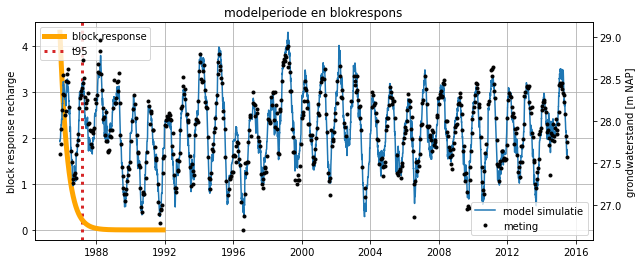

In [23]:
# get response function
sm = ml1.stressmodels['recharge']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(10, 4))
block_resp = resp_func.block(
    ml1.get_parameters('recharge'), cutoff=0.999999)

# plot response function
ax.plot(pd.date_range(ml1.settings['tmin'], periods=len(block_resp)), block_resp, label='block response',
        color='orange', lw=5)
ax.grid()
ax.set_ylabel('block response recharge')
# ax.set_ylim(0,6)
ax.set_title('modelperiode en blokrespons')

# plot t95 response functie
t95 = ml1.stressmodels['recharge'].rfunc.get_tmax(
    ml1.get_parameters('recharge'), cutoff=0.95)
t95_dt = ml1.settings['tmin'] + dt.timedelta(t95)
ylim = ax.get_ylim()
ax.vlines(t95_dt, -100, 100, ls=':', color='C3', label='t95', lw=3)
ax.set_ylim(ylim)
ax.legend(loc=2)

# plot model results
ax2 = ax.twinx()
ax2.plot(ml1.simulate(), label='model simulatie')  # , lw=0.2)
ax2.plot(ml1.oseries.series_original[:], marker='.', ls='', color='k', label='meting')
ax2.set_ylabel('grondwaterstand [m NAP]')
# ax2.set_ylim(28,31)
ax2.legend(loc=4);

<hr>

#### Voorbeeld geheugen 2

Voor een ander voorbeeldmodel is ook de blokrespons en de modelresultaten in één figuur geplot. Bij dit model is de lengte van het tijdreeksmodel kleiner dan het geheugen van de responsfunctie.

In [24]:
ml_voorbeeld = ps.io.load(os.path.join('data', 'voorbeeld_geheugen.pas'))
ml_voorbeeld.solve(report=False)

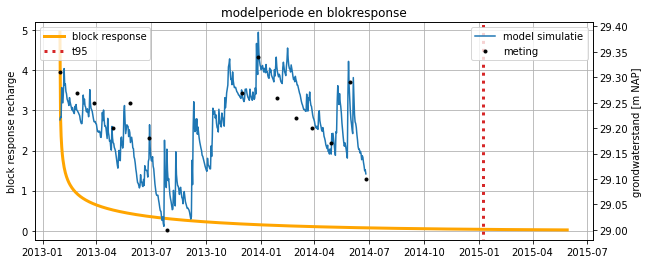

In [25]:
# get response functie
sm = ml_voorbeeld.stressmodels['recharge']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(10, 4))
block_resp = resp_func.block(
    ml_voorbeeld.get_parameters('recharge'), cutoff=0.97)

# plot response functie
ax.plot(pd.date_range(ml_voorbeeld.settings['tmin'], periods=len(block_resp)), block_resp,
        label='block response',
        color='orange', lw=3)
ax.grid()
ax.set_ylabel('block response recharge')
ax.set_title('modelperiode en blokresponse')

# plot t95 response functie
t95 = ml_voorbeeld.stressmodels['recharge'].rfunc.get_tmax(
    ml_voorbeeld.get_parameters('recharge'), cutoff=0.95)
t95_dt = ml_voorbeeld.settings['tmin'] + dt.timedelta(t95)
ylim = ax.get_ylim()
ax.vlines(t95_dt, -100, 100, ls=':', color='C3', label='t95', lw=3)
ax.set_ylim(ylim)

ax.legend(loc=2)

# plot model results
ax2 = ax.twinx()
ax2.plot(ml_voorbeeld.simulate(), label='model simulatie')  # , lw=0.2)
ax2.plot(ml_voorbeeld.oseries.series_original,
         marker='.', ls='', color='k', label='meting')
ax2.set_ylabel('grondwaterstand [m NAP]')
ax2.legend(loc=1);

### Ruimtelijke beoordeling

<p style="color:red">%% PM %%</p>

<hr>

#### Voorbeeld hydrologische ruimtelijke beoordeling

Een voorbeeld van ruimtelijke beoordeling van tijdreeksmodellen wordt gegeven aan de hand van een voorbeeld uit [Collenteur (datum)](#referenties). In die studie zijn tijdreeksmodellen afgeleid voor peilbuizen binnen een straal van 5 km rondom een drinkwater winning van Brabant Water bij Seppe. In deze tijdreeksmodellen zijn neerslag, verdamping en het onttrekkingsdebiet van winning Seppe als verklarende variabelen meegenomen. Vervolgens zijn de tijdreeksmodellen geoptimaliseerd. In onderstaande figuur zijn de berekende stationaire invloeden (ook wel bekend als de 'gain') van de winning Seppe uitgezet tegen de afstand tussen de verschillende peilbuizen en de winlocatie. Daarbij is onderscheid gemaakt tussen peilbuizen in het eerste en tweede watervoerende pakket. De verticale balken geven de onzekerheid aan, en komen overeen met 2 maal de standaardafwijking. De stationaire invloed is berekend voor een onttrekkingsdebiet van 1 miljoen m$^3$/jaar. In de figuur is ook de stationaire invloed van de onttrekking als functie van de afstand berekend met een 2-laags analytisch elementen grondwatermodel (TimML, zie [Bakker et al. (2003)](#referenties)).

<br>
<center><img src='data/drawdown_screenshot.png' alt="Berekende stationaire invloed winning Seppe als functie van de afstand bij onttrekking van 1 Mm^3/jaar" width=50% align='center' /></center>

<center><b><em>Berekende stationaire invloed winning Seppe als functie van de afstand bij onttrekking van 1 Mm$^3$/jaar (Bron: Collenteur, (%% datum %%))</em></b></center>

<br>


Elk tijdreeksmodel is onafhankelijk van de andere modellen; er wordt per model op basis van de gemeten stijghoogtes ingeschat wat de bijdrages van neerslag, verdamping en onttrekking zijn op de verandering in de grondwaterstand. Het berekende patroon van een grotere verlaging nabij de winning past goed op de theoretische invloed van een onttrekking. Ook het verschil tussen het eerste en tweede watervoerende pakket is duidelijk op te maken uit de resultaten van de tijdreeksmodellen. 

Op basis van deze resultaten is het aannemelijk dat de tijdreeksmodellen goed in staat zijn de invloed van de winning Seppe in te schatten. Het geeft vertrouwen dat deze onafhankelijke modellen een plausibel verlagingsbeeld berekenen. 

<p style="color:red"> %% verbeteren zin: Daarmee is het te beargumenteren dat deze modellen toegepast kunnen worden om de invloed van veranderingen in het onttrekkingsdebiet van Seppe op de grondwaterstand te berekenen. %%</p>

Een hydrologische beschouwing van de resultaten van meerdere tijdreeksmodellen kan dus waardevol zijn in de beoordeling van die tijdreeksmodellen. 

<hr>

## Discussie

<p style="color:red"> %% PM: wat komt hier? %% </p>

## Referenties<a id='referenties'></a>

<p style="color:red"> %% PM: invullen referenties %% </p>

- Collenteur (Seppe)
- Bakker, M., and O.D.L. Strack. 2003. Analytic Elements for Multiaquifer Flow. Journal of Hydrology, 271(1-4), 119-129.
- Jackson et al. (2019) Introductory overview: Error metrics for hydrological modelling - A review of common practices and an open source library to facilitate use and adoption. Environmental Modelling & Software 119, 32-48.
- van Geer, F. (2012) Tijdreeksanalyse: Introductie en aandachtspunten. Stromingen 18, nummer 2.
- Knotters, M. (2012) Validatie van tijdreeksmodellen voor de grondwaterstand. Stromingen 18, nummer 2.
- Poeter, E. & Anderson, D. (2005) Multimodel Ranking and Inference in Ground Water Modeling. Ground Water 43, 597-605